# Aggregation of Power Systems Optimization Models - Part I

Consider the following model:

![alt text](img/model.png "Model")

The goal is to find $r$ such that $|r|<<|h|$ but keeping results as close as posible to those obtained with $h$.

In the following cells an example is shown using a testbed using **Pyomo** to run aggregated and complete versions of this model.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np                          # library used for linear algebra and vectorized operations
import openpyxl
import os
import pandas as pd
import pyomo.environ as pyo
import seaborn as sns
import testbed

from sklearn.cluster import KMeans          # sklearn is a library used for machine learning models
from sklearn_extra.cluster import KMedoids  # sklearn_extra is an extension of sklearn with additional machine learning algorithms
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings(action='ignore')     # if getting some boring warnings


In [2]:
# We can export the variables, first create a folder and then export the results
slvr = 'glpk'     # change according to the solver installed in your machine
results_complete = testbed.run_complete_case(folder='data', case='complete_single_node.xlsx', solver=slvr)

df_complete, df_hourly = testbed.export_complete_solution(results_complete, 'complete_single_node')
df_complete



complete
of_value   7.000903e+08
thermal    2.378023e+06
renewable  1.244741e+06
nsp        1.278567e+05

In [3]:
# extracting the duals
df_complete_duals = testbed.extract_duals(results_complete, 'complete_single_node')
df_complete_duals

period  eBalance  eNSP  eMinProd_t1  eMinProd_w1  eMaxProd_t1  \
0          1      24.0   0.0          0.0          0.0          0.0   
1          2      24.0   0.0          0.0          0.0          0.0   
2          3      24.0   0.0          0.0          0.0          0.0   
3          4       3.0   0.0          0.0          0.0          0.0   
4          5       3.0   0.0          0.0          0.0          0.0   
...      ...       ...   ...          ...          ...          ...   
8731    8732      24.0   0.0          0.0          0.0          0.0   
8732    8733      24.0   0.0          0.0          0.0          0.0   
8733    8734      24.0   0.0          0.0          0.0          0.0   
8734    8735      24.0   0.0          0.0          0.0          0.0   
8735    8736      24.0   0.0          0.0          0.0          0.0   

      eMaxProd_w1  
0           -21.0  
1           -21.0  
2           -21.0  
3             0.0  
4             0.0  
...           ...  
8731        -21.0  
8732        -21.0  
8733        -21.0  
8734        -21.0  
8735        -21.0  

[8736 rows x 7 columns]

## Data Wrangling and Exploration
Let us load the input space of the model, time to practice a little of data wrangling and plotting.

In [4]:
df_cf = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='cap_factors')
df_demand = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='demand')

In [5]:
df_demand.head()

period      demand
0       1  363.727832
1       2  319.511974
2       3  250.935275
3       4  182.028803
4       5  130.522977

In [6]:
df_cf.head()

period generator  cap_factor
0       1        w1        0.35
1       2        w1        0.38
2       3        w1        0.41
3       4        w1        0.47
4       5        w1        0.53

In [7]:
# we don't need the generator column for this example so let us remove it
df_cf.drop(columns=['generator'], inplace=True)
df_cf.head()

period  cap_factor
0       1        0.35
1       2        0.38
2       3        0.41
3       4        0.47
4       5        0.53

In [8]:
# join the dataframes and plot the input data of the model
df_input = pd.merge(left=df_demand, left_on='period', right=df_cf, right_on='period')
df_input.head()

period      demand  cap_factor
0       1  363.727832        0.35
1       2  319.511974        0.38
2       3  250.935275        0.41
3       4  182.028803        0.47
4       5  130.522977        0.53

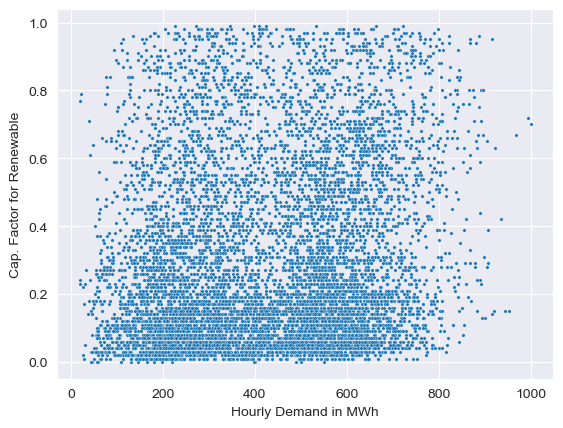

In [12]:
ax = sns.scatterplot(df_input, x='demand', y='cap_factor', s=6)
ax.set_ylabel('Cap. Factor for Renewable')
ax.set_xlabel('Hourly Demand in MWh')
plt.show()


## Clustering the Input Data
Now let us take the input data and cluster it using the good old k-Means. Look at the clustering notebook for the details; also note that in this case the data isn't normalized nor scaled, so we must transform it. We'll leave the Capacity Factors as they are and just scale the demand with its maximum value, though this doesn't mean that this is the best choice. In clustering models, data normalization is a topic of its own, like representative selection or the number of clusters.

In [13]:
df_input['demand_scaled'] = df_input['demand'] / df_input['demand'].max()
clusterer = KMeans(n_clusters = 3, random_state = 50, max_iter = 1000, n_init = 'auto')
# clusterer = KMedoids(n_clusters = 3, random_state = 50, max_iter = 1000)


df_input_clust = df_input.loc[:, ['cap_factor', 'demand_scaled']].copy()
clusterer.fit(df_input_clust)

df_input_clust["labels"] = clusterer.labels_ + 1

df_centroids = pd.DataFrame(clusterer.cluster_centers_[:, 0:2])
df_centroids.columns = ['cap_factor', 'demand']
df_centroids

cap_factor    demand
0    0.160507  0.246573
1    0.684842  0.477227
2    0.164836  0.579690

This centroid doesn't make sense for the demand, we need to 'reverse' the scaling

In [14]:
df_centroids['demand'] = df_centroids['demand'] * df_input['demand'].max()
df_centroids

cap_factor      demand
0    0.160507  246.572550
1    0.684842  477.227212
2    0.164836  579.689729

Time to add the *weights*

In [15]:
weights = df_input_clust.groupby('labels').count().reset_index(drop=True).loc[:, 'cap_factor']
weights.rename('weight', inplace=True)
df_centroids = pd.merge(left=df_centroids, right=weights, left_index=True, right_index=True)
df_centroids

cap_factor      demand  weight
0    0.160507  246.572550    3188
1    0.684842  477.227212    2447
2    0.164836  579.689729    3101

## Aggregated model
Time to run the aggregated model, configure the Excel file as indicated in the picture.
The code is configured to used *aggregated_single/config.xlsx* as the default location, but you can specify your own

![alt text](img/config_agg.png "Model")


In [16]:
# config file can also be auto generated when sending the centroid data
df_config = testbed.generate_config(df_centroids, folder='aggregated_single')
df_config

basis  centroid_demand  centroid_cf  weight
0  bs_auto1       246.572550     0.160507    3188
1  bs_auto2       477.227212     0.684842    2447
2  bs_auto3       579.689729     0.164836    3101

In [17]:
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single'), # location of the aggregated model
                                  solver=slvr, file='config_auto.xlsx')             # configuration file with aggregation information

# results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single'), # location of the aggregated model
#                                   solver=slvr, file='config.xlsx')                  # configuration file with aggregation information

df_agg = testbed.export_aggregated_solution(results, 'aggregated_single')
df_comparison = testbed.export_model_comparison(df_complete, df_agg)

In [18]:
df_agg

basis      of_value       thermal      renewable  nsp  weight
0  bs_auto1  1.349294e+07  5.302246e+05  255848.731600  0.0    3188
1  bs_auto2  1.043061e+07  3.298706e+05  837904.368594  0.0    2447
2  bs_auto3  3.777570e+07  1.542040e+06  255577.746456  0.0    3101

In [19]:
df_comparison

result      complete    aggregated         delta  rel_delta
0       of_value  7.000903e+08  6.169924e+07  6.383911e+08   0.911870
1        thermal  2.378023e+06  2.402135e+06 -2.411240e+04  -0.010140
2      renewable  1.244741e+06  1.349331e+06 -1.045902e+05  -0.084026
3            nsp  1.278567e+05  0.000000e+00  1.278567e+05   1.000000
4  decision_vars  2.620800e+04  9.000000e+00  2.619900e+04   0.999657

## Exploring Different Numbers of Clusters

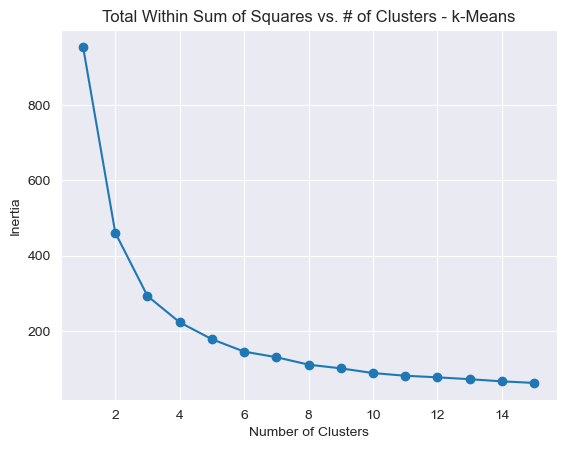

In [20]:
# try a different number of cluster arrangements
n_cluster = range(1, 16)

# when coding in general, and especially in Python, one must try to avoid for/while loops; the within brackets notation is called
# a list comprehension and is an efficient way to create lists in Python which can be then transformed in to numerical arrays.
kmeans = [ KMeans(n_clusters=i, random_state=123, n_init=1).fit(df_input.loc[:, ['cap_factor', 'demand_scaled']]) for i in n_cluster ]

# scikit learn already calculates the inertia for the clustering object in the inertia_ property
inertias = [ kmeans[i].inertia_ for i in range(len(kmeans)) ]

fig, ax = plt.subplots()
ax.plot(n_cluster, inertias, marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
plt.title('Total Within Sum of Squares vs. # of Clusters - k-Means')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4852023358607274
For n_clusters = 3 The average silhouette_score is : 0.44040035172277053
For n_clusters = 4 The average silhouette_score is : 0.4313375502013746
For n_clusters = 5 The average silhouette_score is : 0.4213831047999134
For n_clusters = 6 The average silhouette_score is : 0.42062355381081223
For n_clusters = 7 The average silhouette_score is : 0.3737197355552346
For n_clusters = 8 The average silhouette_score is : 0.3683798226687479
For n_clusters = 9 The average silhouette_score is : 0.36820259875344785
For n_clusters = 10 The average silhouette_score is : 0.36119890037953045
For n_clusters = 11 The average silhouette_score is : 0.3623991619359433
For n_clusters = 12 The average silhouette_score is : 0.3582129400281254
For n_clusters = 13 The average silhouette_score is : 0.34176665902387493
For n_clusters = 14 The average silhouette_score is : 0.33762558262246084
For n_clusters = 15 The average silhouette_score is :

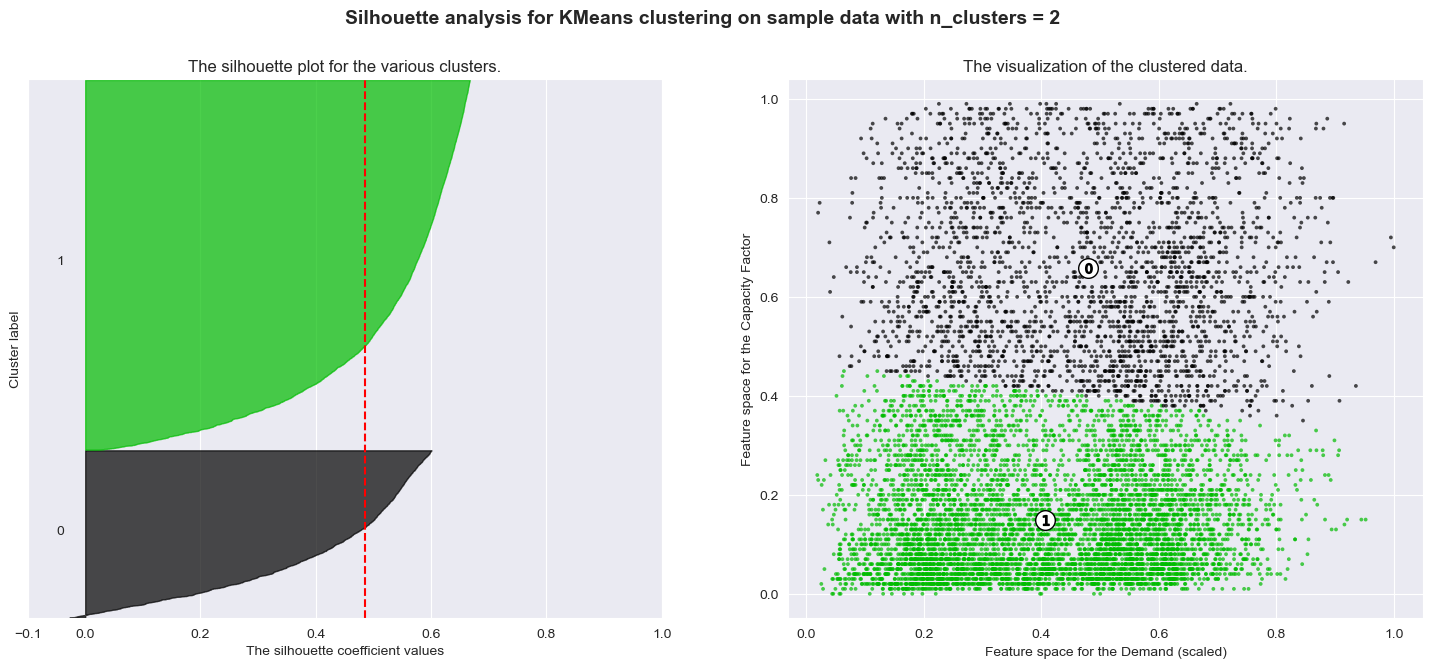

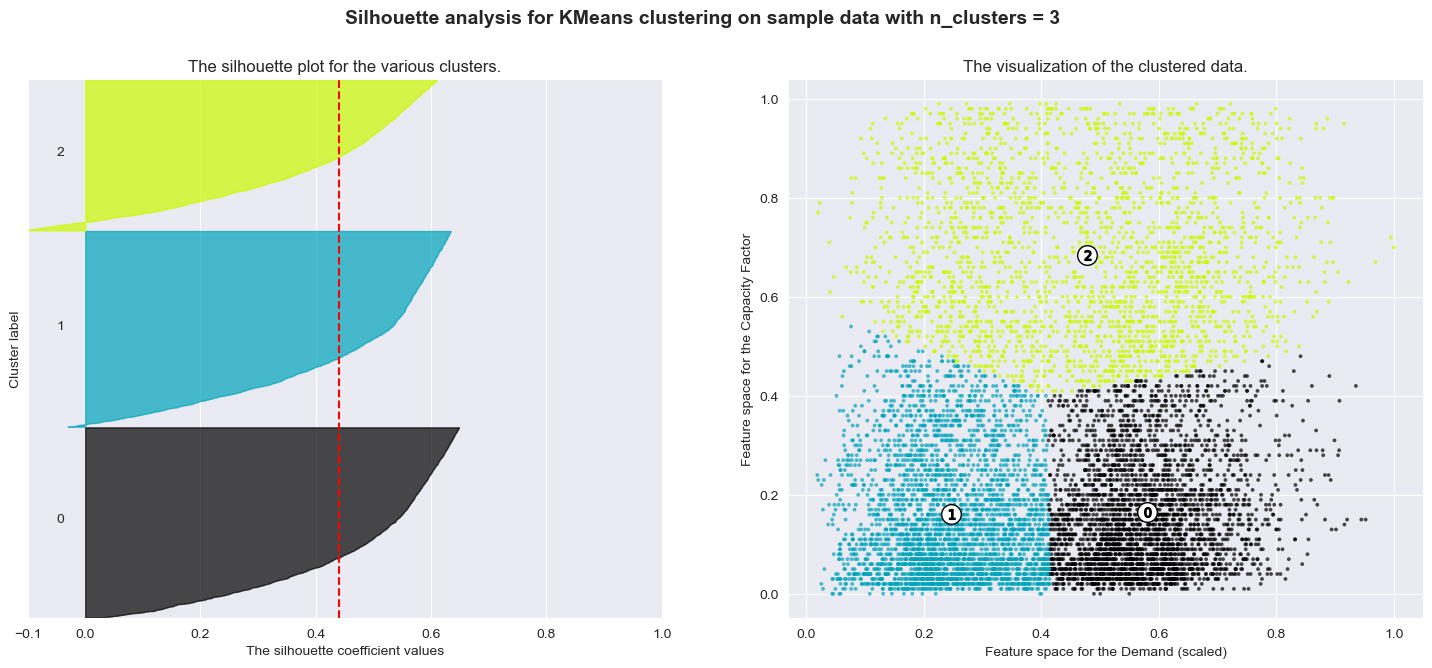

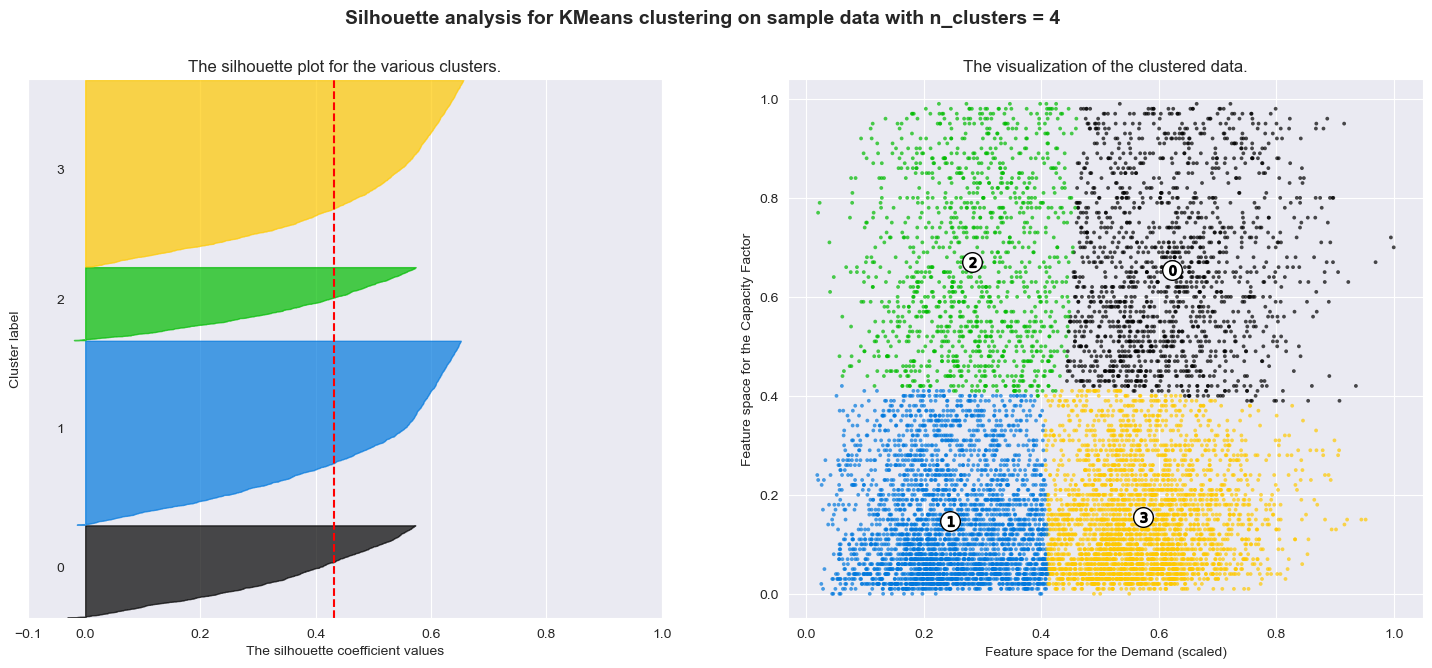

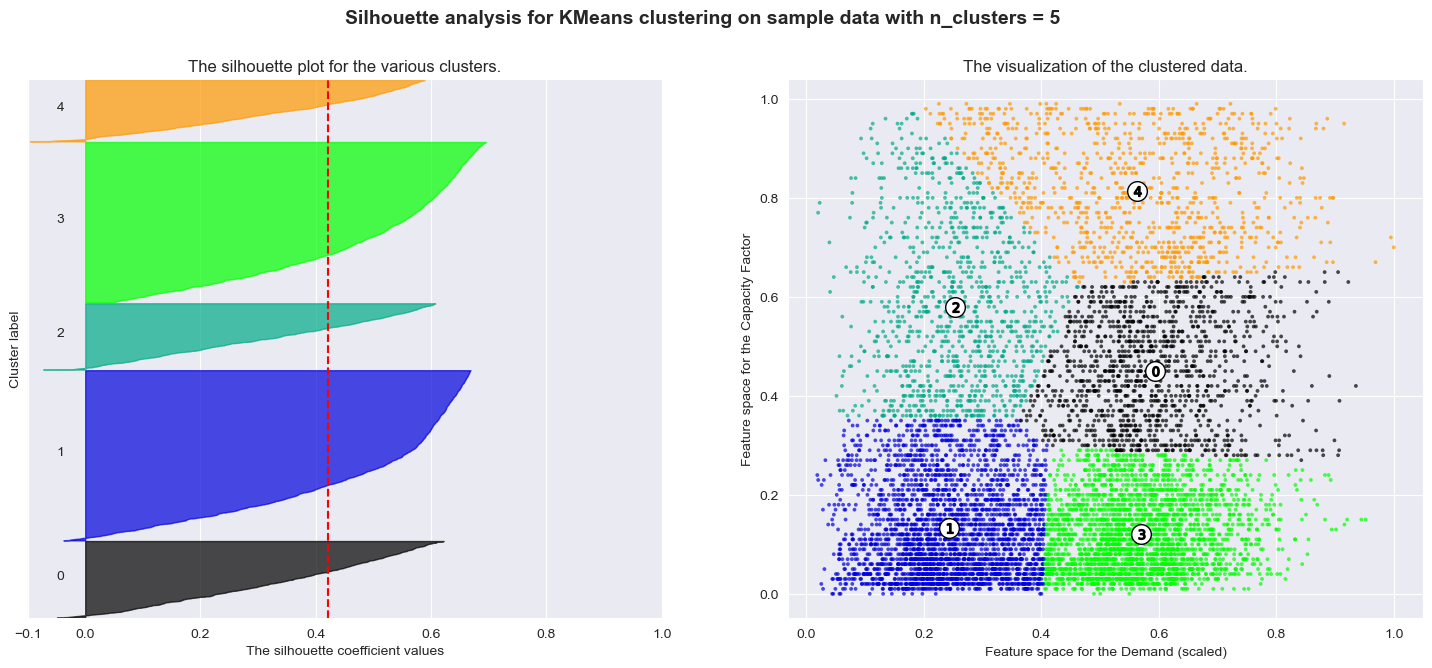

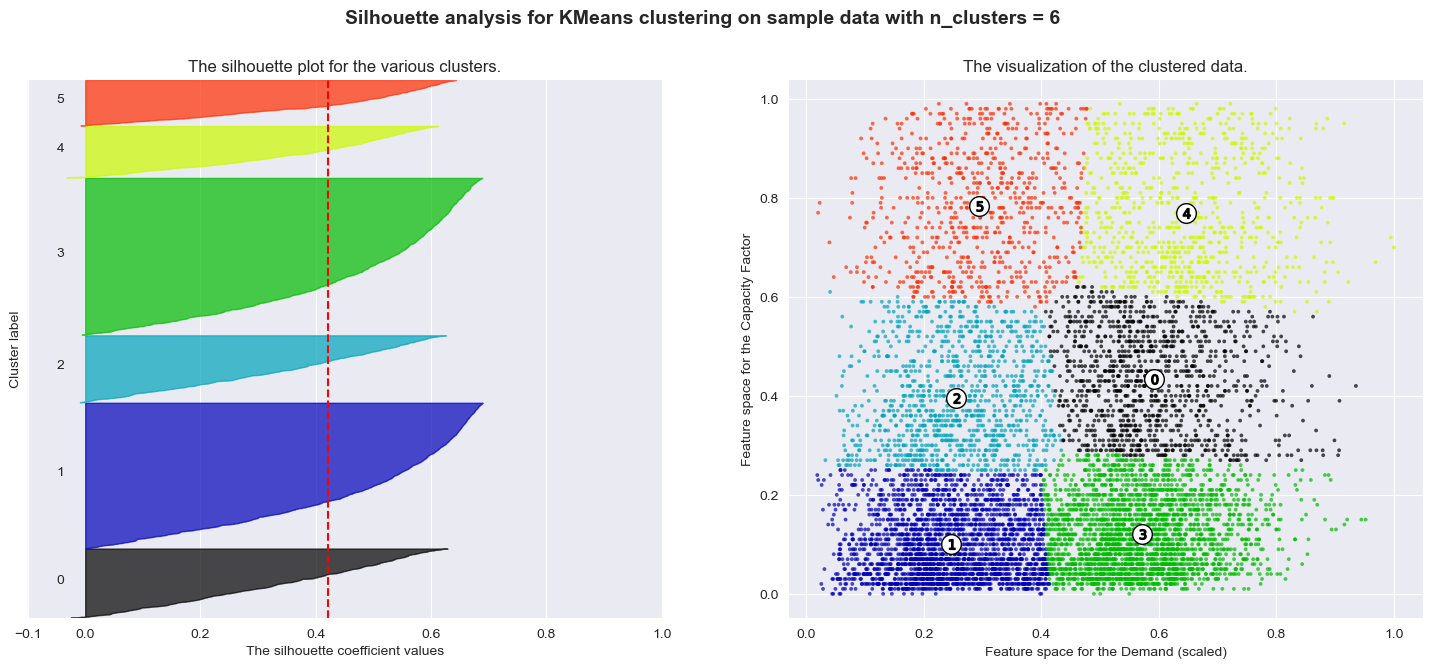

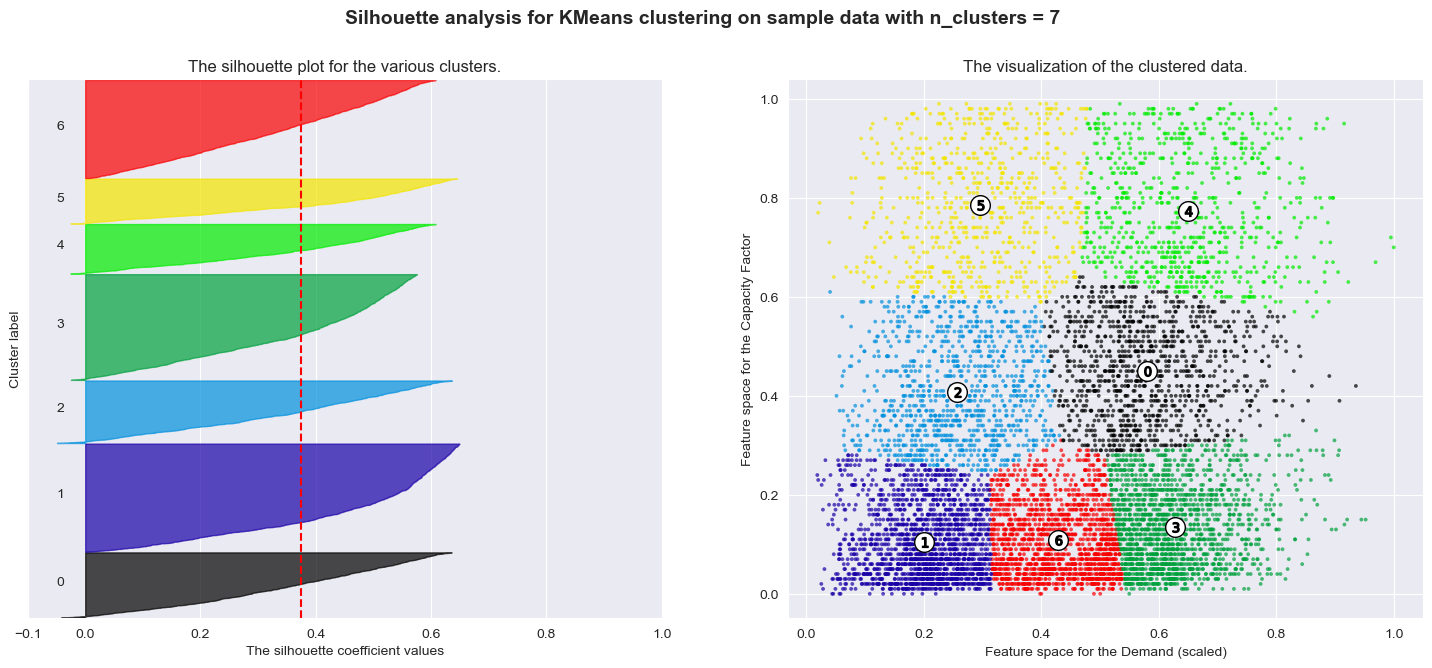

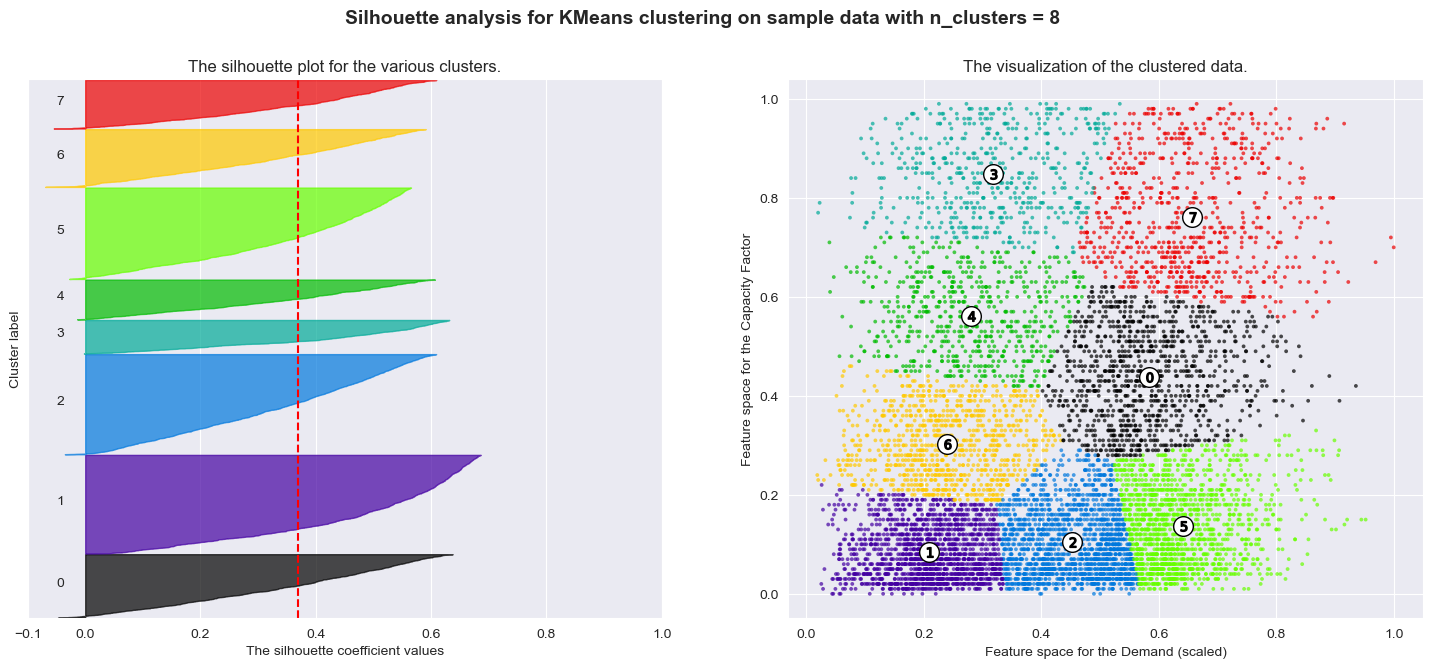

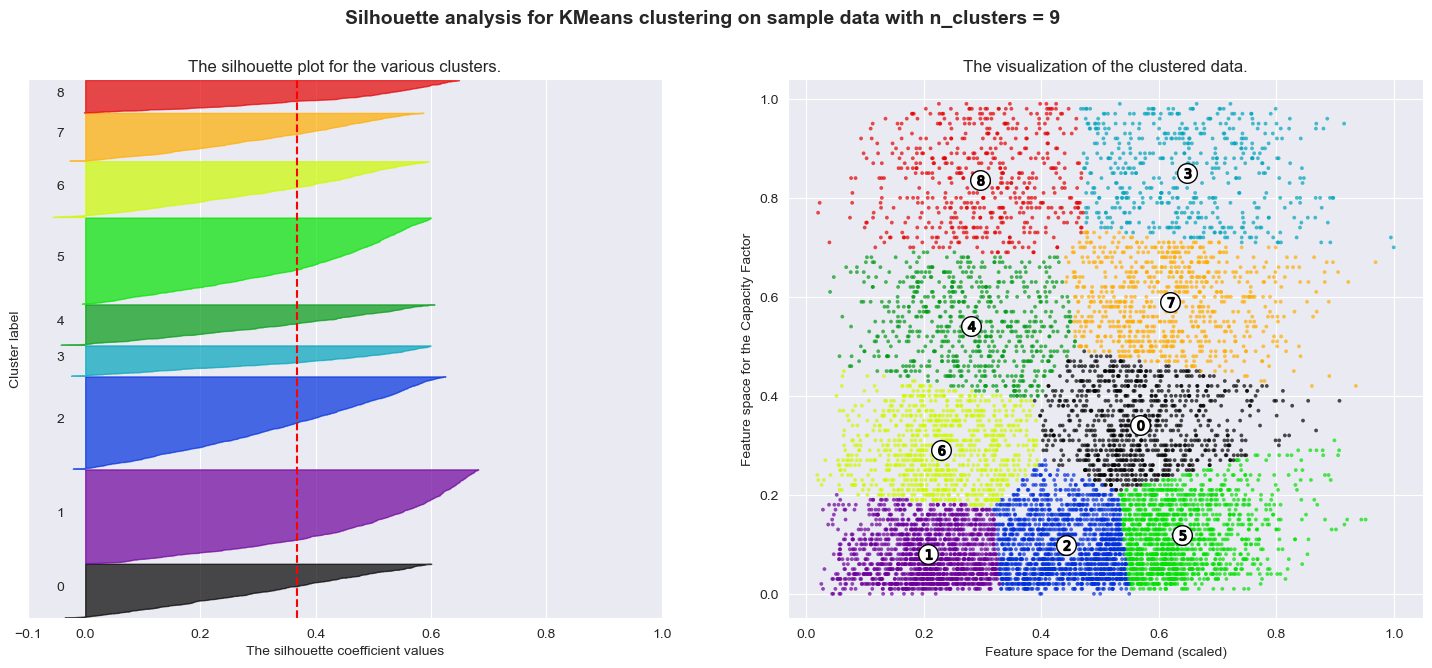

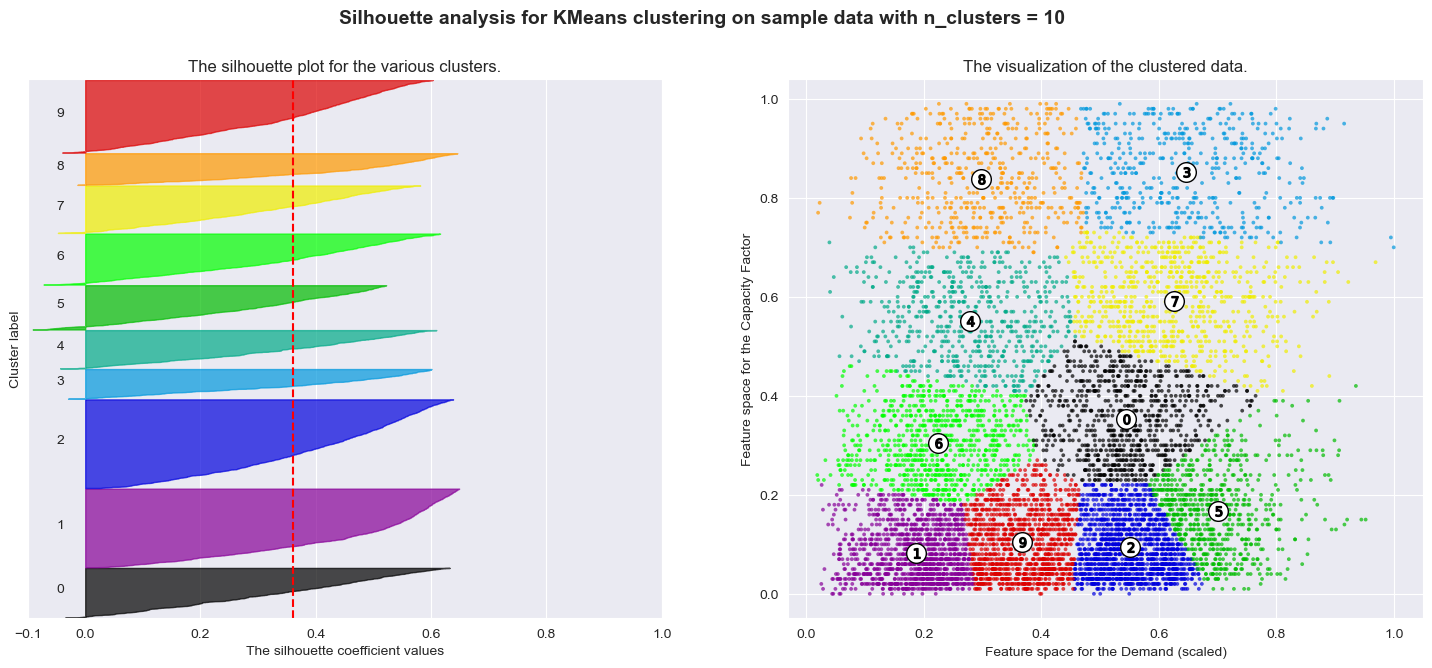

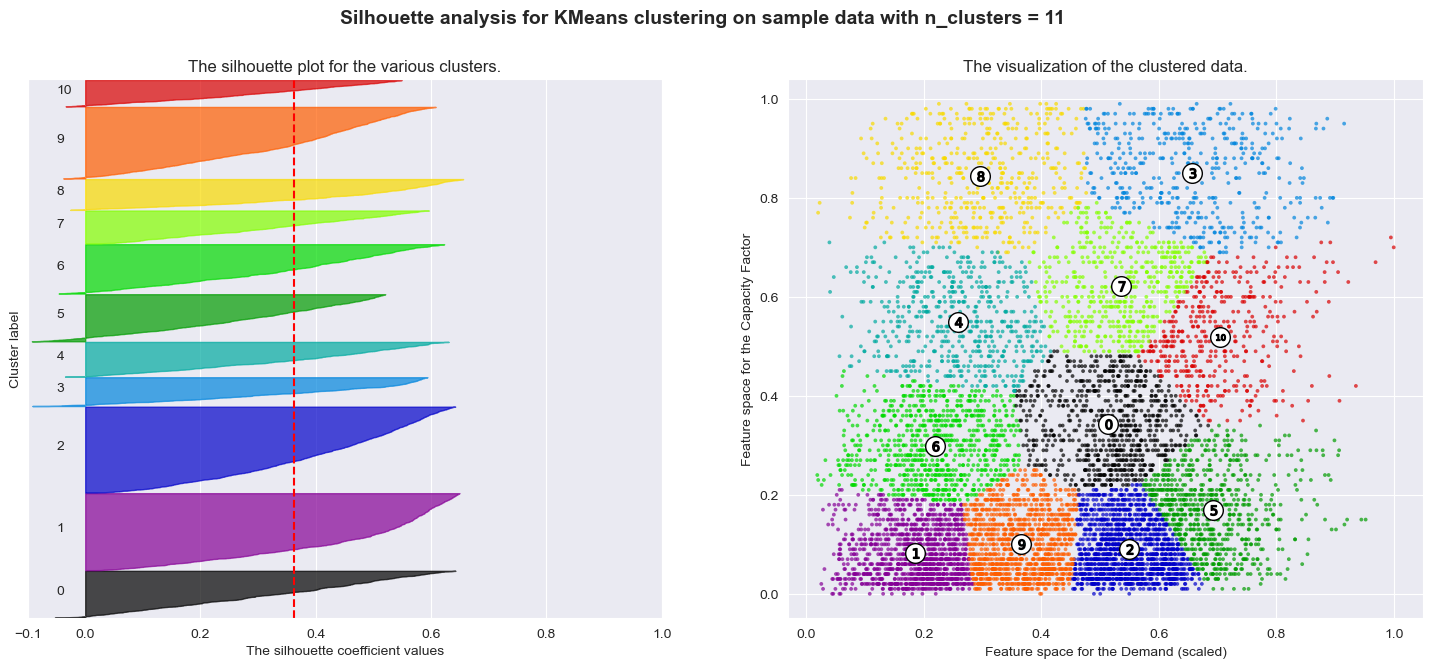

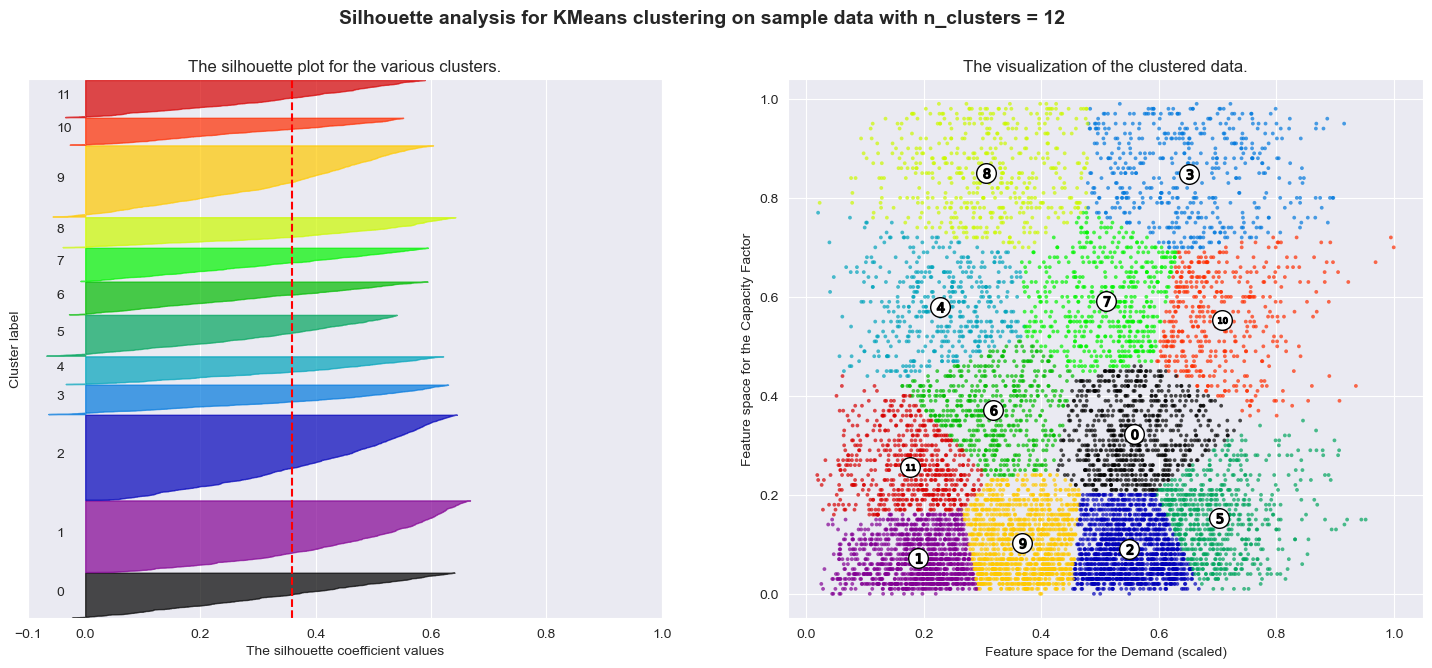

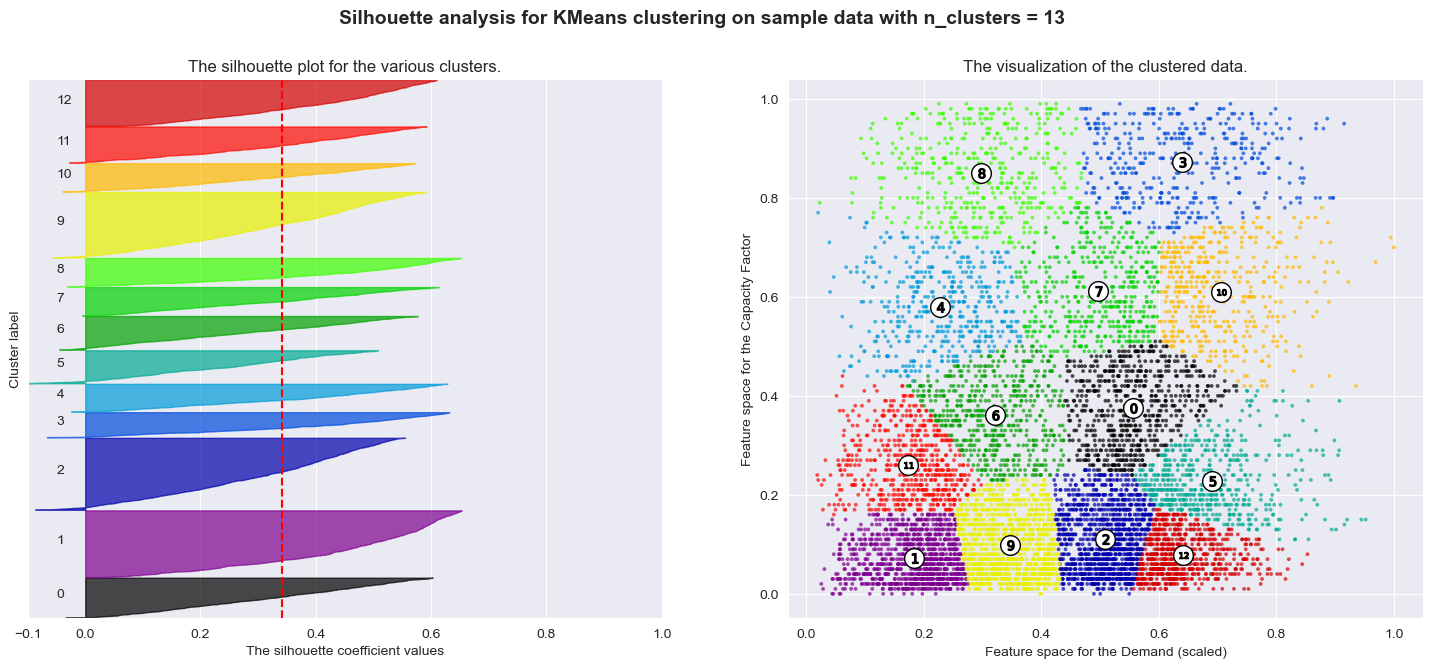

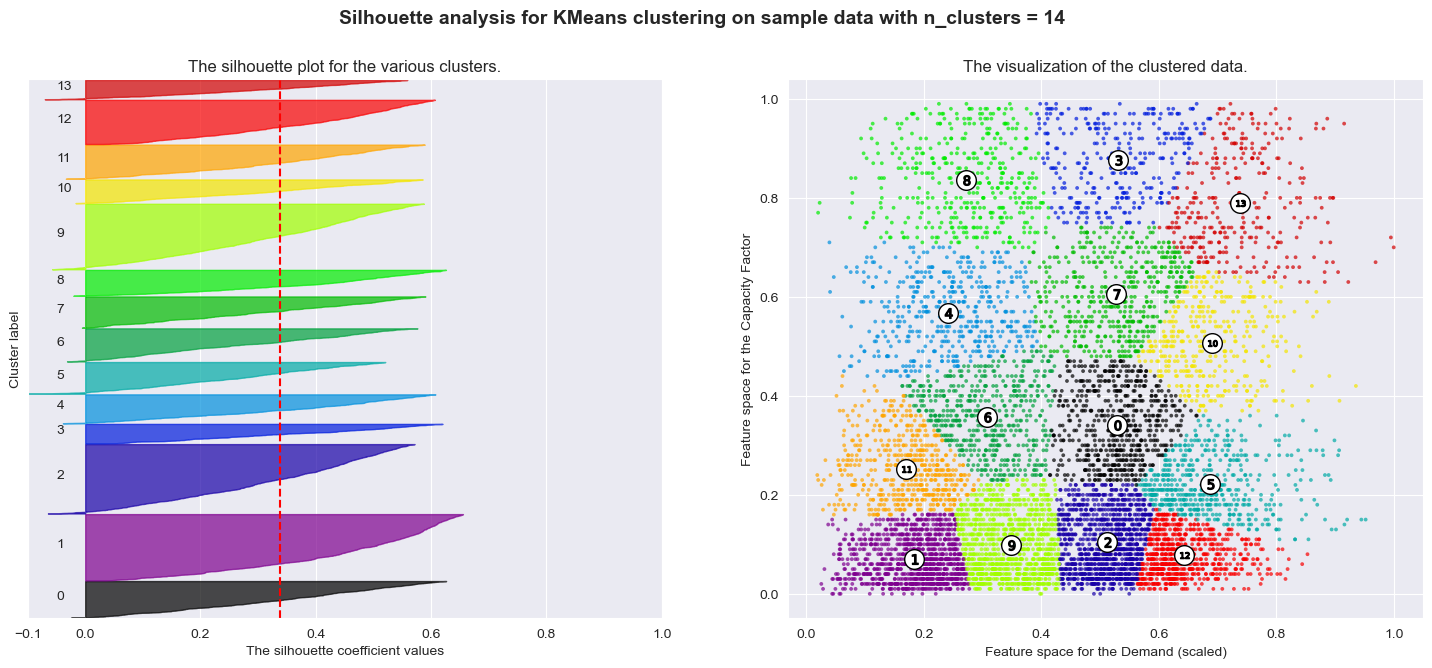

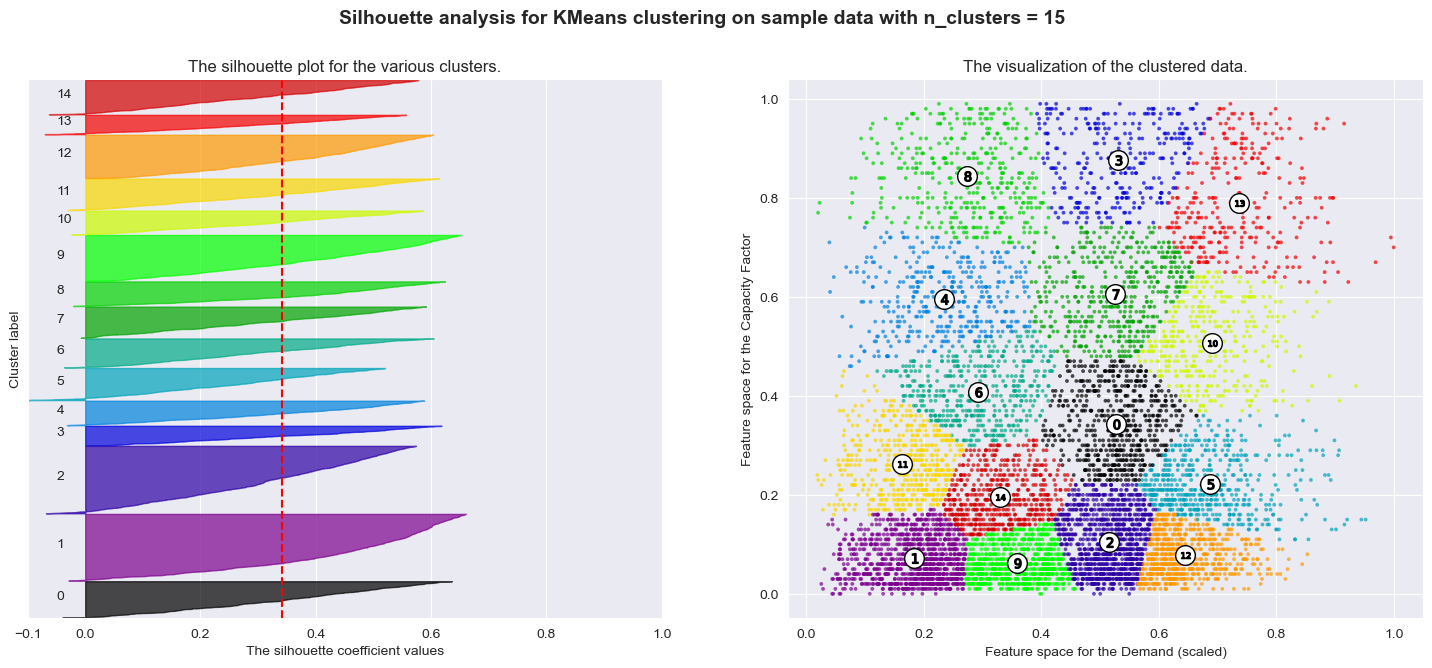

In [21]:
dataset = df_input.loc[:, ['demand_scaled', 'cap_factor']]
for c in n_cluster[1:]:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (c+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dataset) + (c + 1) * 10])

    # Initialize the clusterer with c value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=c, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(dataset)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dataset, cluster_labels)
    print(
        "For n_clusters =",
        c,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

    y_lower = 10
    for i in range(c):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / c)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / c)
    ax2.scatter(
        dataset.iloc[:, 0], dataset.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, ctr in enumerate(centers):
        ax2.scatter(ctr[0], ctr[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the Demand (scaled)")
    ax2.set_ylabel("Feature space for the Capacity Factor")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % c,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

## Extreme Periods
A lot of research has shown the importance of extreme periods in the approximation of aggregated Power System Optimization Models, in this case, let us identify the period with the highest hourly cost

In [22]:
hourly_cost = []
periods = []

for x in results_complete.vCost:
    hourly_cost.append(pyo.value(results_complete.vCost[x]))
    periods.append(int(x))

df_cost = pd.DataFrame({'period': periods, 'hourly_cost': hourly_cost})
# express cost in relative terms with the respect to the highest
df_cost['rel_hourly_cost'] = df_cost['hourly_cost'] / df_cost['hourly_cost'].max()
# let us join the cost data with the inputs
df_input = pd.merge(left=df_input, left_on='period', right=df_cost, right_on='period')


In [23]:
ext_period = df_input['hourly_cost'].argmax() + 1 # plus one because it returns index position, which begins at zero
ext_period

8443

In [24]:
# this period should be added to your config file with weight of one
df_input[df_input.period == ext_period]

period     demand  cap_factor  demand_scaled  hourly_cost  \
8442    8443  952.18123        0.15       0.952181   1898131.15   

      rel_hourly_cost  
8442              1.0

So now we have to cluster all the other periods leaving out our approximation of an *extreme*

In [25]:
clusterer = KMeans(n_clusters = 3, random_state = 50, max_iter = 1000, n_init = 'auto')
# clusterer = KMedoids(n_clusters = 3, random_state = 50, max_iter = 1000)


# notice how we exclude the extreme in the index
df_input_clust_ext = df_input.loc[df_input['period'] != ext_period, ['cap_factor', 'demand_scaled']].copy()


clusterer.fit(df_input_clust_ext)

df_input_clust_ext["labels"] = clusterer.labels_ + 1

df_centroids_ext = pd.DataFrame(clusterer.cluster_centers_[:, 0:2])
df_centroids_ext.columns = ['cap_factor', 'demand']
df_centroids_ext

cap_factor    demand
0    0.160558  0.246310
1    0.684249  0.477571
2    0.164242  0.579230

In [26]:
df_centroids_ext['demand'] = df_centroids_ext['demand'] * df_input['demand'].max()
df_centroids_ext


cap_factor      demand
0    0.160558  246.309841
1    0.684249  477.571349
2    0.164242  579.229639

In [27]:
weights = df_input_clust_ext.groupby('labels').count().reset_index(drop=True).loc[:, 'cap_factor']
weights.rename('weight', inplace=True)
df_centroids_ext = pd.merge(left=df_centroids_ext, right=weights, left_index=True, right_index=True)
# note how the weight columns adds up to 8735 instead of 8736
df_centroids_ext

cap_factor      demand  weight
0    0.160558  246.309841    3183
1    0.684249  477.571349    2449
2    0.164242  579.229639    3103

Update your Excel file with the new **centroids, weights and adding a row for the extreme period** and then run the model again
The code is configured to used *aggregated_single_ext/config_ext.xlsx* as the default location, but you can specify your own

![alt text](img/config_agg_ext.png "Model")

In [28]:
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single_ext'), # location of the aggregated model
                                  solver=slvr, file='config_ext.xlsx')              # configuration file with aggregation information
df_agg_ext = testbed.export_aggregated_solution(results, 'aggregated_single_ext')
df_agg_ext

basis      of_value       thermal    renewable        nsp  weight
0   bs1  1.345001e+07  5.284762e+05  255528.0570    0.00000    3183
1   bs2  1.047461e+07  3.317093e+05  837862.9005    0.00000    2449
2   bs3  3.778514e+07  1.542528e+06  254821.4630    0.00000    3103
3   bs4  1.898131e+06  5.000000e+02      75.0000  377.18123       1

In [29]:
df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
df_comparison_ext

result      complete    aggregated         delta  rel_delta
0       of_value  7.000903e+08  6.360789e+07  6.364824e+08   0.909143
1        thermal  2.378023e+06  2.403214e+06 -2.519072e+04  -0.010593
2      renewable  1.244741e+06  1.348287e+06 -1.035468e+05  -0.083187
3            nsp  1.278567e+05  3.771812e+02  1.274795e+05   0.997050
4  decision_vars  2.620800e+04  1.200000e+01  2.619600e+04   0.999542

In [30]:
df_comparison

result      complete    aggregated         delta  rel_delta
0       of_value  7.000903e+08  6.169924e+07  6.383911e+08   0.911870
1        thermal  2.378023e+06  2.402135e+06 -2.411240e+04  -0.010140
2      renewable  1.244741e+06  1.349331e+06 -1.045902e+05  -0.084026
3            nsp  1.278567e+05  0.000000e+00  1.278567e+05   1.000000
4  decision_vars  2.620800e+04  9.000000e+00  2.619900e+04   0.999657

The relative delta column is calculated as
\
$\textrm{rel_delta}=1-\frac{OF_{agg}}{OF_{complete}}$

so, the model **without** considering the extreme period has an error of 91.18% while the one considering it has an error of 90.91%

### Adding Extreme Periods in a more General Way

In [31]:
# idx = df_hourly['vNSP'] > 0
# periods to exclude, we have to do it with a boolean mask
excl_periods = [1, 24, 1001, 5000]

idx = df_input['period'].isin(excl_periods)
# negate the .isin() mask, so it becomes not in
idx = ~idx
# filter the data with the negated mask
df_input_clust_ext = df_input.loc[idx, ['cap_factor', 'demand_scaled']].copy()

clusterer = KMeans(n_clusters = 3, random_state = 50, max_iter = 1000, n_init = 'auto')
# clusterer = KMedoids(n_clusters = 3, random_state = 50, max_iter = 1000)

clusterer.fit(df_input_clust_ext)
df_input_clust_ext["labels"] = clusterer.labels_ + 1
df_centroids_ext = pd.DataFrame(clusterer.cluster_centers_[:, 0:2])
df_centroids_ext.columns = ['cap_factor', 'demand']
df_centroids_ext['demand'] = df_centroids_ext['demand'] * df_input['demand'].max()
weights = df_input_clust_ext.groupby('labels').count().reset_index(drop=True).loc[:, 'cap_factor']
weights.rename('weight', inplace=True)
df_centroids_ext = pd.merge(left=df_centroids_ext, right=weights, left_index=True, right_index=True)
df_centroids_ext


cap_factor      demand  weight
0     0.16219  577.163238    3121
1     0.68290  478.513573    2455
2     0.16147  244.289887    3156

Now is time to add the *excluded* periods, first let us select them from the input

In [32]:
# remember that idx doesn't have the excluded positions because it was negated
df_excluded = df_input.loc[~idx, ['cap_factor', 'demand']].copy()
df_excluded['weight'] = 1
df_excluded

cap_factor      demand  weight
0           0.35  363.727832       1
23          0.84  431.774757       1
1000        0.89  246.795793       1
4999        0.08  191.663107       1

Now append them to centroids from the clustering, generate the config and run

In [33]:
df_centroids_ext = df_centroids_ext.append(df_excluded, ignore_index=True)
df_config_ext = testbed.generate_config(df_centroids_ext, folder='aggregated_single_ext')
df_config_ext

basis  centroid_demand  centroid_cf  weight
0  bs_auto1       577.163238      0.16219    3121
1  bs_auto2       478.513573      0.68290    2455
2  bs_auto3       244.289887      0.16147    3156
3  bs_auto4       363.727832      0.35000       1
4  bs_auto5       431.774757      0.84000       1
5  bs_auto6       246.795793      0.89000       1
6  bs_auto7       191.663107      0.08000       1

In [34]:
# and now the execution and result comparison
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single_ext'), # location of the aggregated model
                                  solver=slvr, file='config_auto.xlsx')              # configuration file with aggregation information
df_agg_ext = testbed.export_aggregated_solution(results, 'aggregated_single_ext')
df_agg_ext

basis      of_value       thermal      renewable  nsp  weight
0  bs_auto1  3.791679e+07  1.548229e+06  253097.335358  0.0    3121
1  bs_auto2  1.059056e+07  3.364908e+05  838260.000000  0.0    2455
2  bs_auto3  1.315269e+07  5.161787e+05  254800.146078  0.0    3156
3  bs_auto4  5.054468e+03  1.887278e+02     175.000000  0.0       1
4  bs_auto5  1.542594e+03  1.177476e+01     420.000000  0.0       1
5  bs_auto6  7.403874e+02  0.000000e+00     246.795793  0.0       1
6  bs_auto7  3.759915e+03  1.516631e+02      40.000000  0.0       1

In [35]:
df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
df_comparison_ext

result      complete    aggregated         delta  rel_delta
0       of_value  7.000903e+08  6.167114e+07  6.384192e+08   0.911910
1        thermal  2.378023e+06  2.401251e+06 -2.322797e+04  -0.009768
2      renewable  1.244741e+06  1.347039e+06 -1.022986e+05  -0.082185
3            nsp  1.278567e+05  0.000000e+00  1.278567e+05   1.000000
4  decision_vars  2.620800e+04  2.100000e+01  2.618700e+04   0.999199

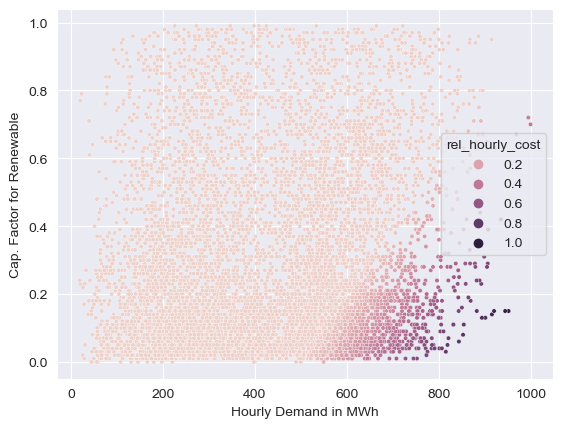

In [36]:

ax = sns.scatterplot(df_input, x='demand', y='cap_factor', hue=df_input['rel_hourly_cost'], s=10)
ax.set_ylabel('Cap. Factor for Renewable')
ax.set_xlabel('Hourly Demand in MWh')
plt.show()
